# Meta-Learner Fusion Training
## Advanced Stacking Ensemble with Cross-Validation and Threshold Optimization

**Project:** Hybrid Fraud Shield  
**Author:** Kiyas Mahmud  
**Date:** November 7, 2025

---

## Objective

Create an optimized meta-learner that fuses ML and DL model predictions using stacking ensemble technique.

## Methodology

**Base Models:**
- 5 Machine Learning Models: Logistic Regression, Random Forest, XGBoost, CatBoost, LightGBM
- 6 Deep Learning Models: FNN, CNN, LSTM, BiLSTM, Hybrid (CNN-BiLSTM), Autoencoder
- Total: 11 base models

**Meta-Learner:**
- Algorithm: Logistic Regression with L2 regularization
- Training: Stratified K-Fold Cross-Validation (5 folds)
- Optimization: GridSearchCV for hyperparameter tuning
- Threshold: Optimized for maximum F1-Score

## Pipeline Steps

1. Load all trained base models (5 ML + 6 DL)
2. Generate probability predictions from all base models
3. Save predictions to disk: p_ml.npy, p_dl.npy
4. Design meta-learner architecture
5. Train with cross-validation on validation set
6. Hyperparameter tuning with GridSearchCV
7. Optimize decision threshold for F1-Score
8. Final evaluation on test set
9. Save meta-learner and deployment configuration

---

## Step 1: Import Libraries and Configuration

In [6]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import json
from datetime import datetime

# Machine Learning libraries
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, average_precision_score,
    precision_recall_curve, confusion_matrix, classification_report
)
import joblib

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

# Plot settings
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("="*80)
print("HYBRID FRAUD SHIELD - Meta-Learner Fusion Training")
print("="*80)
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print("="*80)

HYBRID FRAUD SHIELD - Meta-Learner Fusion Training
Started at: 2025-11-07 22:08:09
TensorFlow version: 2.18.1
Keras version: 3.11.2


## Step 2: Load Train/Validation/Test Data

Load the preprocessed data with proper train/validation/test splits (60/20/20).

In [7]:
# Load dataset
data_path = r'../../data/train_72_features.csv'
df = pd.read_csv(data_path)

print("="*80)
print("DATA LOADING")
print("="*80)
print(f"\nDataset: {df.shape}")
print(f"Features: {df.shape[1] - 1}")
print(f"Fraud cases: {df['isFraud'].sum():,} ({df['isFraud'].mean()*100:.2f}%)")
print(f"Normal cases: {(~df['isFraud'].astype(bool)).sum():,}")

# Separate features and target
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Import train_test_split
from sklearn.model_selection import train_test_split

# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Second split: 20% validation, 20% test (from the 40% temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n{'-'*80}")
print("Data Split (Stratified 60/20/20):")
print(f"{'-'*80}")
print(f"Train: {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%) - Fraud: {y_train.sum():,} ({y_train.mean()*100:.2f}%)")
print(f"Val:   {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%) - Fraud: {y_val.sum():,} ({y_val.mean()*100:.2f}%)")
print(f"Test:  {len(X_test):,} samples ({len(X_test)/len(df)*100:.1f}%) - Fraud: {y_test.sum():,} ({y_test.mean()*100:.2f}%)")

# Scale data for DL models and Logistic Regression
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# Keep unscaled versions for tree-based models
X_train_unscaled = X_train.copy()
X_val_unscaled = X_val.copy()
X_test_unscaled = X_test.copy()

print(f"\nData prepared: scaled and unscaled versions created")
print("="*80)

DATA LOADING

Dataset: (590540, 72)
Features: 71
Fraud cases: 20,663 (3.50%)
Normal cases: 569,877

--------------------------------------------------------------------------------
Data Split (Stratified 60/20/20):
--------------------------------------------------------------------------------
Train: 354,324 samples (60.0%) - Fraud: 12,398 (3.50%)
Val:   118,108 samples (20.0%) - Fraud: 4,133 (3.50%)
Test:  118,108 samples (20.0%) - Fraud: 4,132 (3.50%)

Data prepared: scaled and unscaled versions created


## Step 3: Load Trained ML Models

Load all 5 trained machine learning models from the ml/models directory.

In [8]:
# Define ML models directory
ml_models_dir = r'../ml/models'

# ML model files
ml_model_files = {
    'Logistic Regression': 'logistic_regression_tuned_72features.pkl',
    'Random Forest': 'random_forest_tuned_72features.pkl',
    'XGBoost': 'xgboost_tuned_72features.pkl',
    'CatBoost': 'catboost_tuned_72features.pkl',
    'LightGBM': 'lightgbm_tuned_72features.pkl'
}

# Load ML models
ml_models = {}
print("\n" + "="*80)
print("LOADING MACHINE LEARNING MODELS")
print("="*80)

for name, filename in ml_model_files.items():
    model_path = os.path.join(ml_models_dir, filename)
    try:
        ml_models[name] = joblib.load(model_path)
        print(f"Loaded: {name:<25} from {filename}")
    except Exception as e:
        print(f"Error loading {name}: {e}")

print(f"\nTotal ML models loaded: {len(ml_models)}/5")
print("="*80)


LOADING MACHINE LEARNING MODELS
Loaded: Logistic Regression       from logistic_regression_tuned_72features.pkl
Loaded: Random Forest             from random_forest_tuned_72features.pkl
Loaded: XGBoost                   from xgboost_tuned_72features.pkl
Loaded: CatBoost                  from catboost_tuned_72features.pkl
Loaded: LightGBM                  from lightgbm_tuned_72features.pkl

Total ML models loaded: 5/5


## Step 4: Load Trained DL Models

Load all 6 trained deep learning models from the dl/saved_models directory.

In [9]:
# Define DL models directory
dl_models_dir = r'../dl/saved_models'

# DL model files
dl_model_files = {
    'FNN': 'fnn_tuned.keras',
    'CNN': 'cnn_tuned.keras',
    'LSTM': 'lstm_tuned.keras',
    'BiLSTM': 'bilstm_tuned.keras',
    'Hybrid': 'hybrid_tuned.keras',
    'Autoencoder': 'autoencoder_tuned.keras'
}

# Load DL models
dl_models = {}
print("\n" + "="*80)
print("LOADING DEEP LEARNING MODELS")
print("="*80)

for name, filename in dl_model_files.items():
    model_path = os.path.join(dl_models_dir, filename)
    try:
        dl_models[name] = load_model(model_path)
        print(f"Loaded: {name:<25} from {filename}")
    except Exception as e:
        print(f"Error loading {name}: {e}")

print(f"\nTotal DL models loaded: {len(dl_models)}/6")
print(f"\n{'='*80}")
print(f"TOTAL BASE MODELS LOADED: {len(ml_models) + len(dl_models)}/11")
print(f"{'='*80}")


LOADING DEEP LEARNING MODELS


Loaded: FNN                       from fnn_tuned.keras
Loaded: CNN                       from cnn_tuned.keras
Loaded: LSTM                      from lstm_tuned.keras
Loaded: BiLSTM                    from bilstm_tuned.keras
Loaded: Hybrid                    from hybrid_tuned.keras
Loaded: Autoencoder               from autoencoder_tuned.keras

Total DL models loaded: 6/6

TOTAL BASE MODELS LOADED: 11/11


## Step 5: Generate ML Model Predictions

Generate probability predictions from all 5 ML models on train, validation, and test sets.

In [10]:
print("\n" + "="*80)
print("GENERATING ML MODEL PREDICTIONS")
print("="*80)

def generate_ml_predictions(models, X_scaled, X_unscaled, set_name):
    """
    Generate predictions from ML models
    
    Parameters:
    -----------
    models : dict
        Dictionary of ML models
    X_scaled : DataFrame
        Scaled features for Logistic Regression
    X_unscaled : DataFrame
        Unscaled features for tree-based models
    set_name : str
        Name of the dataset (train/val/test)
    
    Returns:
    --------
    np.ndarray : Array of predictions (n_samples, n_models)
    list : List of model names
    """
    predictions = []
    model_names = []
    
    print(f"\n{set_name} Set:")
    print("-"*80)
    
    for name, model in models.items():
        # Use scaled data for Logistic Regression, unscaled for tree models
        if name == 'Logistic Regression':
            X_input = X_scaled
        else:
            X_input = X_unscaled
        
        # Get probability for fraud class (class 1)
        proba = model.predict_proba(X_input)[:, 1]
        predictions.append(proba)
        model_names.append(name)
        print(f"  {name:<25} : {proba.shape[0]:,} predictions generated")
    
    return np.column_stack(predictions), model_names

# Generate predictions for all sets
p_ml_train, ml_names = generate_ml_predictions(ml_models, X_train_scaled, X_train_unscaled, "Train")
p_ml_val, _ = generate_ml_predictions(ml_models, X_val_scaled, X_val_unscaled, "Validation")
p_ml_test, _ = generate_ml_predictions(ml_models, X_test_scaled, X_test_unscaled, "Test")

print(f"\n{'='*80}")
print(f"ML Predictions Summary:")
print(f"  Models: {len(ml_names)}")
print(f"  Train: {p_ml_train.shape}")
print(f"  Val:   {p_ml_val.shape}")
print(f"  Test:  {p_ml_test.shape}")
print(f"{'='*80}")


GENERATING ML MODEL PREDICTIONS

Train Set:
--------------------------------------------------------------------------------
  Logistic Regression       : 354,324 predictions generated
  Random Forest             : 354,324 predictions generated
  XGBoost                   : 354,324 predictions generated
  CatBoost                  : 354,324 predictions generated
  LightGBM                  : 354,324 predictions generated

Validation Set:
--------------------------------------------------------------------------------
  Logistic Regression       : 118,108 predictions generated
  Random Forest             : 118,108 predictions generated
  XGBoost                   : 118,108 predictions generated
  CatBoost                  : 118,108 predictions generated
  LightGBM                  : 118,108 predictions generated

Test Set:
--------------------------------------------------------------------------------
  Logistic Regression       : 118,108 predictions generated
  Random Forest         

## Step 6: Generate DL Model Predictions

Generate probability predictions from all 6 DL models on train, validation, and test sets.

In [11]:
print("\n" + "="*80)
print("GENERATING DL MODEL PREDICTIONS")
print("="*80)

def generate_dl_predictions(models, X_scaled, set_name):
    """
    Generate predictions from DL models
    
    Parameters:
    -----------
    models : dict
        Dictionary of DL models
    X_scaled : DataFrame
        Scaled features for all DL models
    set_name : str
        Name of the dataset (train/val/test)
    
    Returns:
    --------
    np.ndarray : Array of predictions (n_samples, n_models)
    list : List of model names
    """
    predictions = []
    model_names = []
    
    print(f"\n{set_name} Set:")
    print("-"*80)
    
    for name, model in models.items():
        if name == 'Autoencoder':
            # For autoencoder, use reconstruction error as anomaly score
            reconstructed = model.predict(X_scaled, verbose=0)
            reconstruction_error = np.mean((X_scaled.values - reconstructed) ** 2, axis=1)
            # Normalize to [0, 1]
            proba = (reconstruction_error - reconstruction_error.min()) / \
                    (reconstruction_error.max() - reconstruction_error.min())
        else:
            # Regular prediction for other DL models
            proba = model.predict(X_scaled, verbose=0).ravel()
        
        predictions.append(proba)
        model_names.append(name)
        print(f"  {name:<25} : {proba.shape[0]:,} predictions generated")
    
    return np.column_stack(predictions), model_names

# Generate predictions for all sets
p_dl_train, dl_names = generate_dl_predictions(dl_models, X_train_scaled, "Train")
p_dl_val, _ = generate_dl_predictions(dl_models, X_val_scaled, "Validation")
p_dl_test, _ = generate_dl_predictions(dl_models, X_test_scaled, "Test")

print(f"\n{'='*80}")
print(f"DL Predictions Summary:")
print(f"  Models: {len(dl_names)}")
print(f"  Train: {p_dl_train.shape}")
print(f"  Val:   {p_dl_val.shape}")
print(f"  Test:  {p_dl_test.shape}")
print(f"{'='*80}")


GENERATING DL MODEL PREDICTIONS

Train Set:
--------------------------------------------------------------------------------
  FNN                       : 354,324 predictions generated
  CNN                       : 354,324 predictions generated
  LSTM                      : 354,324 predictions generated
  BiLSTM                    : 354,324 predictions generated
  Hybrid                    : 354,324 predictions generated
  Autoencoder               : 354,324 predictions generated

Validation Set:
--------------------------------------------------------------------------------
  FNN                       : 118,108 predictions generated
  CNN                       : 118,108 predictions generated
  LSTM                      : 118,108 predictions generated
  BiLSTM                    : 118,108 predictions generated
  Hybrid                    : 118,108 predictions generated
  Autoencoder               : 118,108 predictions generated

Test Set:
---------------------------------------------

## Step 7: Combine All Predictions

Combine ML and DL predictions into single arrays for meta-learner training.

In [12]:
# Combine ML and DL predictions
p_all_train = np.column_stack([p_ml_train, p_dl_train])
p_all_val = np.column_stack([p_ml_val, p_dl_val])
p_all_test = np.column_stack([p_ml_test, p_dl_test])

# Combined model names
all_model_names = ml_names + dl_names

print("\n" + "="*80)
print("COMBINED PREDICTIONS")
print("="*80)
print(f"\nAll Models: {all_model_names}")
print(f"\nShapes:")
print(f"  Train: {p_all_train.shape} ({p_all_train.shape[0]:,} samples x {p_all_train.shape[1]} models)")
print(f"  Val:   {p_all_val.shape} ({p_all_val.shape[0]:,} samples x {p_all_val.shape[1]} models)")
print(f"  Test:  {p_all_test.shape} ({p_all_test.shape[0]:,} samples x {p_all_test.shape[1]} models)")
print("="*80)


COMBINED PREDICTIONS

All Models: ['Logistic Regression', 'Random Forest', 'XGBoost', 'CatBoost', 'LightGBM', 'FNN', 'CNN', 'LSTM', 'BiLSTM', 'Hybrid', 'Autoencoder']

Shapes:
  Train: (354324, 11) (354,324 samples x 11 models)
  Val:   (118108, 11) (118,108 samples x 11 models)
  Test:  (118108, 11) (118,108 samples x 11 models)


## Step 8: Save Predictions to Files

Save all predictions and metadata to disk for future use.

In [13]:
# Create directories
os.makedirs('predictions', exist_ok=True)
os.makedirs('saved_models', exist_ok=True)

print("\n" + "="*80)
print("SAVING PREDICTIONS TO FILES")
print("="*80)

# Save ML predictions
np.save('predictions/p_ml_train.npy', p_ml_train)
np.save('predictions/p_ml_val.npy', p_ml_val)
np.save('predictions/p_ml_test.npy', p_ml_test)
print("\nML Predictions saved:")
print("  - predictions/p_ml_train.npy")
print("  - predictions/p_ml_val.npy")
print("  - predictions/p_ml_test.npy")

# Save DL predictions
np.save('predictions/p_dl_train.npy', p_dl_train)
np.save('predictions/p_dl_val.npy', p_dl_val)
np.save('predictions/p_dl_test.npy', p_dl_test)
print("\nDL Predictions saved:")
print("  - predictions/p_dl_train.npy")
print("  - predictions/p_dl_val.npy")
print("  - predictions/p_dl_test.npy")

# Save combined predictions
np.save('predictions/p_all_train.npy', p_all_train)
np.save('predictions/p_all_val.npy', p_all_val)
np.save('predictions/p_all_test.npy', p_all_test)
print("\nCombined Predictions saved:")
print("  - predictions/p_all_train.npy")
print("  - predictions/p_all_val.npy")
print("  - predictions/p_all_test.npy")

# Save labels
np.save('predictions/y_train.npy', y_train)
np.save('predictions/y_val.npy', y_val)
np.save('predictions/y_test.npy', y_test)
print("\nLabels saved:")
print("  - predictions/y_train.npy")
print("  - predictions/y_val.npy")
print("  - predictions/y_test.npy")

# Save model information
model_info = {
    'ml_models': ml_names,
    'dl_models': dl_names,
    'all_models': all_model_names,
    'n_ml_models': len(ml_names),
    'n_dl_models': len(dl_names),
    'n_total_models': len(all_model_names),
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('predictions/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print("\nModel Information saved:")
print("  - predictions/model_info.json")

print("\n" + "="*80)
print("ALL PREDICTIONS SAVED SUCCESSFULLY")
print("="*80)


SAVING PREDICTIONS TO FILES

ML Predictions saved:
  - predictions/p_ml_train.npy
  - predictions/p_ml_val.npy
  - predictions/p_ml_test.npy

DL Predictions saved:
  - predictions/p_dl_train.npy
  - predictions/p_dl_val.npy
  - predictions/p_dl_test.npy

Combined Predictions saved:
  - predictions/p_all_train.npy
  - predictions/p_all_val.npy
  - predictions/p_all_test.npy

Labels saved:
  - predictions/y_train.npy
  - predictions/y_val.npy
  - predictions/y_test.npy

Model Information saved:
  - predictions/model_info.json

ALL PREDICTIONS SAVED SUCCESSFULLY


## Step 9: Design Meta-Learner Architecture

Create a Logistic Regression meta-learner with L2 regularization and balanced class weights.

In [14]:
print("\n" + "="*80)
print("META-LEARNER ARCHITECTURE")
print("="*80)

# Initialize meta-learner
meta_learner = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

print("\nMeta-Learner Configuration:")
print("-"*80)
print(f"  Algorithm: Logistic Regression")
print(f"  Penalty: L2 (Ridge)")
print(f"  Regularization (C): 1.0")
print(f"  Solver: lbfgs")
print(f"  Max Iterations: 1000")
print(f"  Class Weight: balanced")
print(f"  Random State: 42")
print(f"  Input Features: {p_all_val.shape[1]} (predictions from base models)")
print(f"  Output: Binary classification (0=Normal, 1=Fraud)")
print("="*80)


META-LEARNER ARCHITECTURE

Meta-Learner Configuration:
--------------------------------------------------------------------------------
  Algorithm: Logistic Regression
  Penalty: L2 (Ridge)
  Regularization (C): 1.0
  Solver: lbfgs
  Max Iterations: 1000
  Class Weight: balanced
  Random State: 42
  Input Features: 11 (predictions from base models)
  Output: Binary classification (0=Normal, 1=Fraud)


## Step 10: Train with Cross-Validation

Train the meta-learner using Stratified K-Fold Cross-Validation on the validation set.

In [15]:
print("\n" + "="*80)
print("CROSS-VALIDATION TRAINING")
print("="*80)

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on validation set
print("\nPerforming 5-Fold Stratified Cross-Validation...")
print("-"*80)

cv_scores = cross_val_score(
    meta_learner,
    p_all_val,
    y_val,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

print("\nCross-Validation F1 Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nCross-Validation Results:")
print(f"  Mean F1-Score: {cv_scores.mean():.4f}")
print(f"  Std F1-Score:  {cv_scores.std():.4f}")
print(f"  95% CI: [{cv_scores.mean() - 2*cv_scores.std():.4f}, {cv_scores.mean() + 2*cv_scores.std():.4f}]")

# Train on full validation set
print(f"\n{'-'*80}")
print("Training meta-learner on full validation set...")
meta_learner.fit(p_all_val, y_val)
print(f"Meta-learner trained on {p_all_val.shape[0]:,} samples")

print("="*80)


CROSS-VALIDATION TRAINING

Performing 5-Fold Stratified Cross-Validation...
--------------------------------------------------------------------------------

Cross-Validation F1 Scores:
  Fold 1: 0.5825
  Fold 2: 0.5806
  Fold 3: 0.5779
  Fold 4: 0.5736
  Fold 5: 0.5784

Cross-Validation Results:
  Mean F1-Score: 0.5786
  Std F1-Score:  0.0030
  95% CI: [0.5726, 0.5846]

--------------------------------------------------------------------------------
Training meta-learner on full validation set...
Meta-learner trained on 118,108 samples


## Step 11: Hyperparameter Tuning

Use GridSearchCV to find optimal hyperparameters for the meta-learner.

In [16]:
print("\n" + "="*80)
print("HYPERPARAMETER TUNING")
print("="*80)

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'max_iter': [500, 1000, 2000]
}

print("\nParameter Grid:")
print("-"*80)
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = len(param_grid['C']) * len(param_grid['solver']) * len(param_grid['max_iter'])
print(f"\nTotal combinations: {total_combinations}")
print(f"Total fits (with 5-fold CV): {total_combinations * 5}")

# Perform grid search
print(f"\n{'-'*80}")
print("Starting GridSearchCV...")
print("-"*80)

grid_search = GridSearchCV(
    LogisticRegression(penalty='l2', random_state=42, class_weight='balanced', n_jobs=-1),
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(p_all_val, y_val)

print("\n" + "="*80)
print("GRID SEARCH RESULTS")
print("="*80)
print(f"\nBest F1 Score (CV): {grid_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Update meta-learner with best parameters
meta_learner = grid_search.best_estimator_
print(f"\nMeta-learner updated with best parameters")

# Display top 5 configurations
print(f"\n{'-'*80}")
print("Top 5 Configurations:")
print("-"*80)
results_df = pd.DataFrame(grid_search.cv_results_)
top_5 = results_df.nsmallest(5, 'rank_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in top_5.iterrows():
    print(f"  F1: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f}) - {row['params']}")

print("="*80)


HYPERPARAMETER TUNING

Parameter Grid:
--------------------------------------------------------------------------------
  C: [0.01, 0.1, 1, 10, 100]
  solver: ['lbfgs', 'liblinear']
  penalty: ['l2']
  max_iter: [500, 1000, 2000]

Total combinations: 30
Total fits (with 5-fold CV): 150

--------------------------------------------------------------------------------
Starting GridSearchCV...
--------------------------------------------------------------------------------
Fitting 5 folds for each of 30 candidates, totalling 150 fits

GRID SEARCH RESULTS

Best F1 Score (CV): 0.5795

Best Parameters:
  C: 100
  max_iter: 500
  penalty: l2
  solver: liblinear

Meta-learner updated with best parameters

--------------------------------------------------------------------------------
Top 5 Configurations:
--------------------------------------------------------------------------------
  F1: 0.5795 (+/- 0.0039) - {'C': 100, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
  F1: 0.5795

## Step 12: Optimize Decision Threshold

Find the optimal classification threshold to maximize F1-Score on the validation set.


THRESHOLD OPTIMIZATION

Testing thresholds from 0.1 to 0.9...

--------------------------------------------------------------------------------
Threshold Optimization Results:
--------------------------------------------------------------------------------
Default threshold (0.5):
  F1-Score:  0.5803
  Precision: 0.4202
  Recall:    0.9371

Optimal threshold (0.89):
  F1-Score:  0.7573
  Precision: 0.6789
  Recall:    0.8563

Improvement: +30.51%


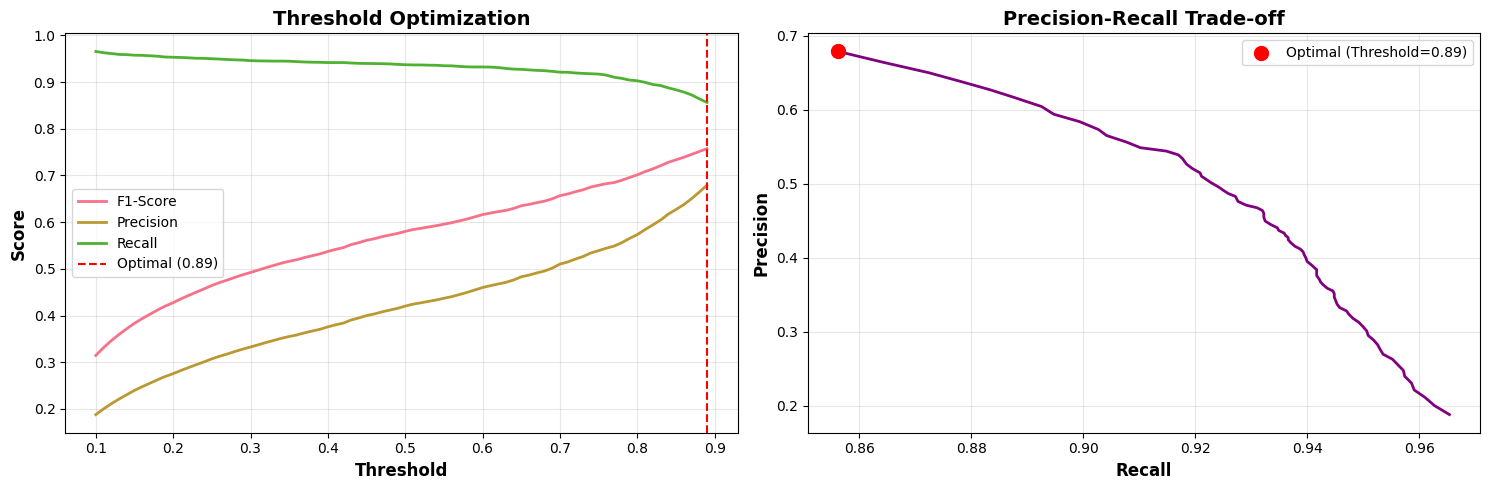


Visualization saved: threshold_optimization.png


In [17]:
print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION")
print("="*80)

# Get probability predictions on validation set
y_val_proba = meta_learner.predict_proba(p_all_val)[:, 1]

# Test different thresholds
thresholds = np.arange(0.1, 0.9, 0.01)
threshold_results = []

print("\nTesting thresholds from 0.1 to 0.9...")
for threshold in thresholds:
    y_pred = (y_val_proba >= threshold).astype(int)
    
    f1 = f1_score(y_val, y_pred, zero_division=0)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    
    threshold_results.append({
        'threshold': threshold,
        'f1_score': f1,
        'precision': precision,
        'recall': recall
    })

# Convert to DataFrame
threshold_df = pd.DataFrame(threshold_results)

# Find optimal threshold
optimal_idx = threshold_df['f1_score'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
optimal_f1 = threshold_df.loc[optimal_idx, 'f1_score']
optimal_precision = threshold_df.loc[optimal_idx, 'precision']
optimal_recall = threshold_df.loc[optimal_idx, 'recall']

print(f"\n{'-'*80}")
print("Threshold Optimization Results:")
print("-"*80)
print(f"Default threshold (0.5):")
default_pred = (y_val_proba >= 0.5).astype(int)
print(f"  F1-Score:  {f1_score(y_val, default_pred):.4f}")
print(f"  Precision: {precision_score(y_val, default_pred):.4f}")
print(f"  Recall:    {recall_score(y_val, default_pred):.4f}")

print(f"\nOptimal threshold ({optimal_threshold:.2f}):")
print(f"  F1-Score:  {optimal_f1:.4f}")
print(f"  Precision: {optimal_precision:.4f}")
print(f"  Recall:    {optimal_recall:.4f}")

improvement = ((optimal_f1 - f1_score(y_val, default_pred)) / f1_score(y_val, default_pred)) * 100
print(f"\nImprovement: {improvement:+.2f}%")

# Visualize threshold optimization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Threshold vs Metrics
axes[0].plot(threshold_df['threshold'], threshold_df['f1_score'], label='F1-Score', linewidth=2)
axes[0].plot(threshold_df['threshold'], threshold_df['precision'], label='Precision', linewidth=2)
axes[0].plot(threshold_df['threshold'], threshold_df['recall'], label='Recall', linewidth=2)
axes[0].axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal ({optimal_threshold:.2f})')
axes[0].set_xlabel('Threshold', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Score', fontweight='bold', fontsize=12)
axes[0].set_title('Threshold Optimization', fontweight='bold', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Plot 2: Precision-Recall Trade-off
axes[1].plot(threshold_df['recall'], threshold_df['precision'], linewidth=2, color='purple')
axes[1].scatter(optimal_recall, optimal_precision, color='red', s=100, zorder=5,
                label=f'Optimal (Threshold={optimal_threshold:.2f})')
axes[1].set_xlabel('Recall', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Precision', fontweight='bold', fontsize=12)
axes[1].set_title('Precision-Recall Trade-off', fontweight='bold', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved: threshold_optimization.png")
print("="*80)

## Step 13: Evaluate on Test Set

Now we evaluate the optimized meta-learner on the held-out test set using the optimal threshold found in Step 12. This provides unbiased performance metrics.


TEST SET EVALUATION

--------------------------------------------------------------------------------
Test Set Performance:
--------------------------------------------------------------------------------
Accuracy:  0.9804
Precision: 0.6745
Recall:    0.8519
F1-Score:  0.7529
ROC-AUC:   0.9777

--------------------------------------------------------------------------------
Confusion Matrix:
--------------------------------------------------------------------------------
True Negatives:  112,277
False Positives: 1,699
False Negatives: 612
True Positives:  3,520

--------------------------------------------------------------------------------
Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.99      0.99    113976
       Fraud       0.67      0.85      0.75      4132

    accuracy                           0.98    118108
   macro avg       0.83    

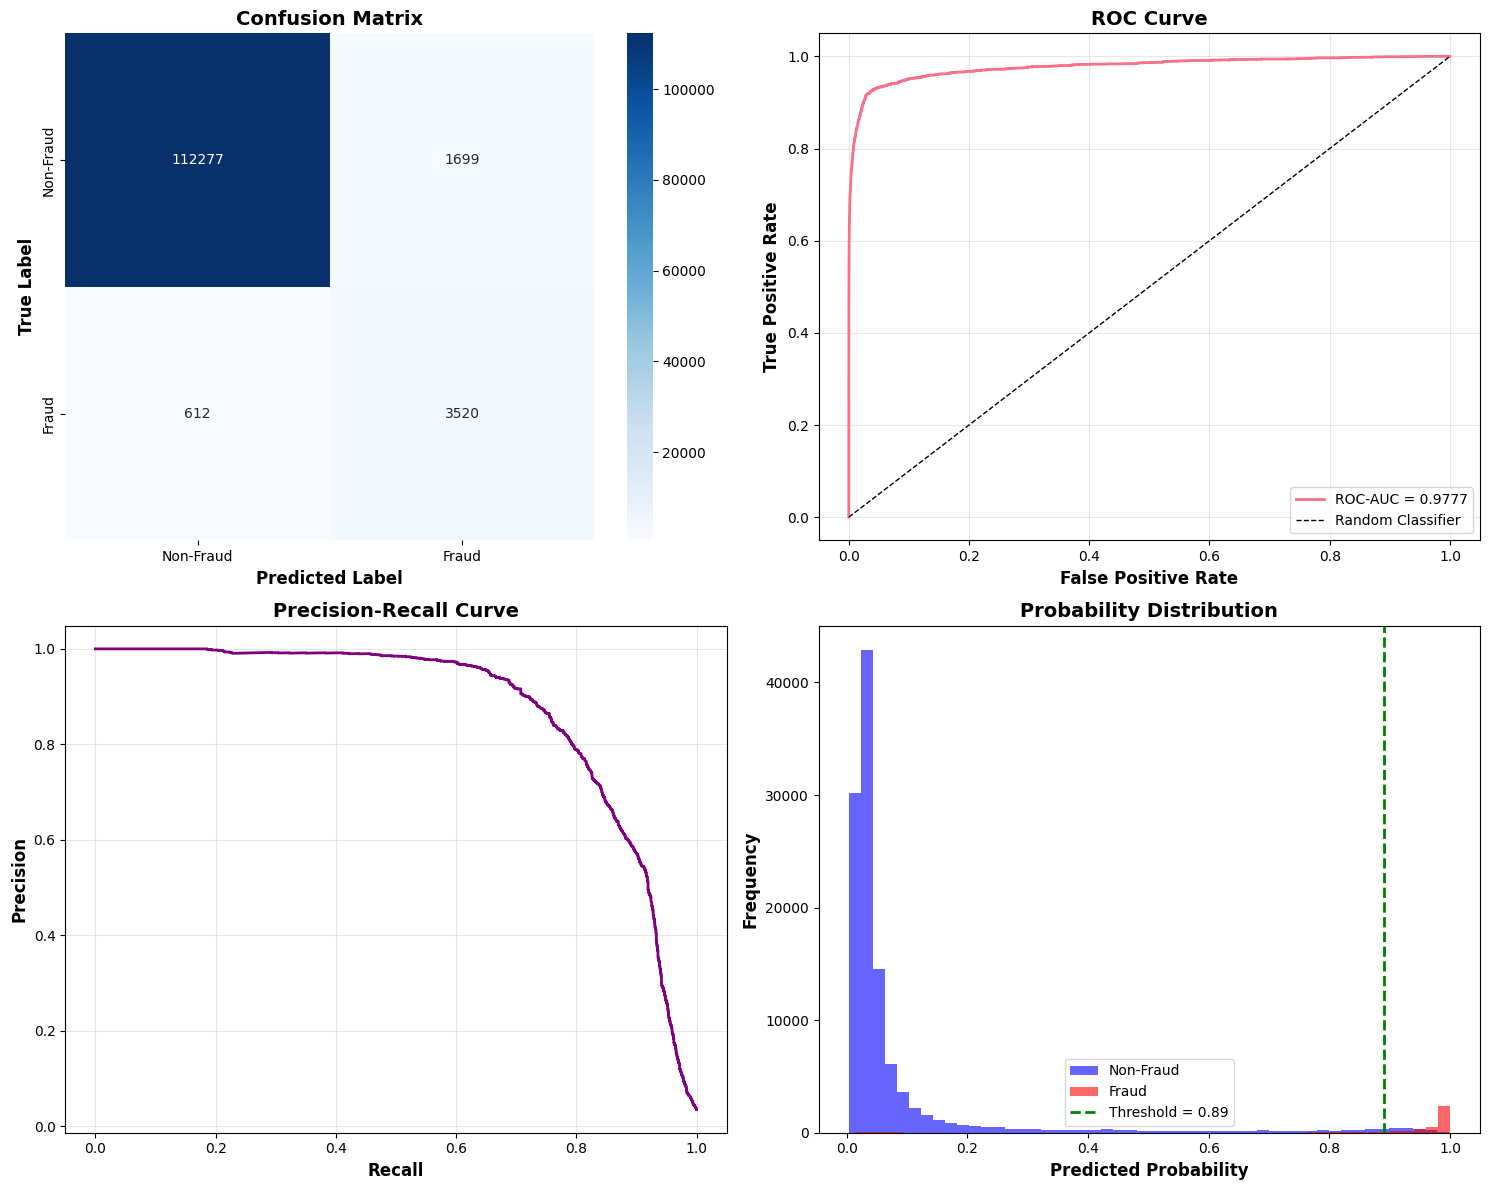


Visualization saved: test_evaluation.png


In [18]:
print("\n" + "="*80)
print("TEST SET EVALUATION")
print("="*80)

# Generate predictions on test set
y_test_proba = meta_learner.predict_proba(p_all_test)[:, 1]
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"\n{'-'*80}")
print("Test Set Performance:")
print("-"*80)
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print(f"\n{'-'*80}")
print("Confusion Matrix:")
print("-"*80)
print(f"True Negatives:  {cm[0, 0]:,}")
print(f"False Positives: {cm[0, 1]:,}")
print(f"False Negatives: {cm[1, 0]:,}")
print(f"True Positives:  {cm[1, 1]:,}")

# Classification Report
print(f"\n{'-'*80}")
print("Classification Report:")
print("-"*80)
print(classification_report(y_test, y_test_pred, target_names=['Non-Fraud', 'Fraud']))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], cbar=True)
axes[0, 0].set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('True Label', fontweight='bold', fontsize=12)
axes[0, 0].set_title('Confusion Matrix', fontweight='bold', fontsize=14)
axes[0, 0].set_xticklabels(['Non-Fraud', 'Fraud'])
axes[0, 0].set_yticklabels(['Non-Fraud', 'Fraud'])

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'ROC-AUC = {test_roc_auc:.4f}')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('True Positive Rate', fontweight='bold', fontsize=12)
axes[0, 1].set_title('ROC Curve', fontweight='bold', fontsize=14)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# Plot 3: Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_test_proba)
axes[1, 0].plot(recall_curve, precision_curve, linewidth=2, color='purple')
axes[1, 0].set_xlabel('Recall', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontweight='bold', fontsize=12)
axes[1, 0].set_title('Precision-Recall Curve', fontweight='bold', fontsize=14)
axes[1, 0].grid(alpha=0.3)

# Plot 4: Probability Distribution
axes[1, 1].hist(y_test_proba[y_test == 0], bins=50, alpha=0.6, label='Non-Fraud', color='blue')
axes[1, 1].hist(y_test_proba[y_test == 1], bins=50, alpha=0.6, label='Fraud', color='red')
axes[1, 1].axvline(optimal_threshold, color='green', linestyle='--', linewidth=2,
                   label=f'Threshold = {optimal_threshold:.2f}')
axes[1, 1].set_xlabel('Predicted Probability', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontweight='bold', fontsize=12)
axes[1, 1].set_title('Probability Distribution', fontweight='bold', fontsize=14)
axes[1, 1].legend(fontsize=10)

plt.tight_layout()
plt.savefig('test_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved: test_evaluation.png")
print("="*80)

## Step 14: Save Meta-Learner and Configuration

Save the trained meta-learner, optimal threshold, and all configuration parameters for future deployment.

In [20]:
print("\n" + "="*80)
print("SAVING META-LEARNER AND CONFIGURATION")
print("="*80)

# Create saved_models directory
saved_models_dir = 'saved_models'
os.makedirs(saved_models_dir, exist_ok=True)

# Save meta-learner model
meta_learner_path = os.path.join(saved_models_dir, 'meta_learner.pkl')
joblib.dump(meta_learner, meta_learner_path)
print(f"\nMeta-learner saved: {meta_learner_path}")

# Save scaler
scaler_path = os.path.join(saved_models_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved: {scaler_path}")

# Prepare configuration dictionary
config = {
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'optimal_threshold': float(optimal_threshold),
    'base_models': {
        'ml_models': list(ml_models.keys()),
        'dl_models': list(dl_models.keys()),
        'total_models': len(all_model_names)
    },
    'meta_learner': {
        'algorithm': 'Logistic Regression',
        'best_params': meta_learner.get_params(),
        'solver': meta_learner.solver,
        'C': float(meta_learner.C),
        'penalty': meta_learner.penalty,
        'max_iter': int(meta_learner.max_iter)
    },
    'performance': {
        'validation': {
            'f1_score': float(optimal_f1),
            'precision': float(optimal_precision),
            'recall': float(optimal_recall)
        },
        'test': {
            'accuracy': float(test_accuracy),
            'precision': float(test_precision),
            'recall': float(test_recall),
            'f1_score': float(test_f1),
            'roc_auc': float(test_roc_auc)
        }
    },
    'data_info': {
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'n_features': X_train.shape[1]
    },
    'grid_search_results': {
        'best_score': float(grid_search.best_score_),
        'best_params': grid_search.best_params_,
        'cv_splits': 5
    }
}

# Save configuration
config_path = os.path.join(saved_models_dir, 'config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)
print(f"Configuration saved: {config_path}")

# Save grid search results
grid_results_df = pd.DataFrame(grid_search.cv_results_)
grid_results_path = os.path.join(saved_models_dir, 'grid_search_results.csv')
grid_results_df.to_csv(grid_results_path, index=False)
print(f"Grid search results saved: {grid_results_path}")

# Create summary report
summary_report = f"""
{'='*80}
META-LEARNER TRAINING SUMMARY
{'='*80}

Training Date: {config['training_date']}

Base Models:
  - ML Models: {', '.join(ml_models.keys())}
  - DL Models: {', '.join(dl_models.keys())}
  - Total: {len(all_model_names)} models

Meta-Learner Configuration:
  - Algorithm: Logistic Regression
  - Solver: {meta_learner.solver}
  - C (Regularization): {meta_learner.C}
  - Penalty: {meta_learner.penalty}
  - Max Iterations: {meta_learner.max_iter}

Optimal Threshold: {optimal_threshold:.4f}

Validation Performance:
  - F1-Score: {optimal_f1:.4f}
  - Precision: {optimal_precision:.4f}
  - Recall: {optimal_recall:.4f}

Test Performance:
  - Accuracy: {test_accuracy:.4f}
  - Precision: {test_precision:.4f}
  - Recall: {test_recall:.4f}
  - F1-Score: {test_f1:.4f}
  - ROC-AUC: {test_roc_auc:.4f}

Dataset Sizes:
  - Train: {len(X_train):,} samples
  - Validation: {len(X_val):,} samples
  - Test: {len(X_test):,} samples

{'='*80}
"""

# Save summary report
summary_path = os.path.join(saved_models_dir, 'training_summary.txt')
with open(summary_path, 'w') as f:
    f.write(summary_report)
print(f"Training summary saved: {summary_path}")

print("\n" + "-"*80)
print("All files saved successfully!")
print("-"*80)
print(summary_report)
print("="*80)


SAVING META-LEARNER AND CONFIGURATION

Meta-learner saved: saved_models\meta_learner.pkl
Scaler saved: saved_models\scaler.pkl
Configuration saved: saved_models\config.json
Grid search results saved: saved_models\grid_search_results.csv
Training summary saved: saved_models\training_summary.txt

--------------------------------------------------------------------------------
All files saved successfully!
--------------------------------------------------------------------------------

META-LEARNER TRAINING SUMMARY

Training Date: 2025-11-07 22:34:09

Base Models:
  - ML Models: Logistic Regression, Random Forest, XGBoost, CatBoost, LightGBM
  - DL Models: FNN, CNN, LSTM, BiLSTM, Hybrid, Autoencoder
  - Total: 11 models

Meta-Learner Configuration:
  - Algorithm: Logistic Regression
  - Solver: liblinear
  - C (Regularization): 100
  - Penalty: l2
  - Max Iterations: 500

Optimal Threshold: 0.8900

Validation Performance:
  - F1-Score: 0.7573
  - Precision: 0.6789
  - Recall: 0.8563

Te

## Step 15: Create Deployment Script

Generate a deployment script that encapsulates the entire meta-learner prediction pipeline for production use.

In [21]:
print("\n" + "="*80)
print("CREATING DEPLOYMENT SCRIPT")
print("="*80)

deployment_script = '''"""
Meta-Learner Fraud Detection Deployment Script
===============================================
This script provides a production-ready interface for fraud detection using
the trained meta-learner ensemble system.

Author: Hybrid Fraud Shield Team
Date: November 7, 2025
"""

import numpy as np
import pandas as pd
import joblib
import json
import os
from tensorflow import keras

class MetaLearnerPredictor:
    """
    Production deployment class for meta-learner fraud detection.
    """
    
    def __init__(self, model_dir='saved_models', ml_dir='../ml/models', dl_dir='../dl/saved_models'):
        """
        Initialize the meta-learner predictor.
        
        Args:
            model_dir: Directory containing meta-learner and config
            ml_dir: Directory containing ML models
            dl_dir: Directory containing DL models
        """
        self.model_dir = model_dir
        self.ml_dir = ml_dir
        self.dl_dir = dl_dir
        
        # Load configuration
        self.config = self._load_config()
        self.optimal_threshold = self.config['optimal_threshold']
        
        # Load models
        self.scaler = self._load_scaler()
        self.meta_learner = self._load_meta_learner()
        self.ml_models = self._load_ml_models()
        self.dl_models = self._load_dl_models()
        
        print("Meta-Learner Predictor initialized successfully!")
        print(f"Optimal Threshold: {self.optimal_threshold:.4f}")
        print(f"Base Models: {self.config['base_models']['total_models']}")
    
    def _load_config(self):
        """Load configuration file."""
        config_path = os.path.join(self.model_dir, 'config.json')
        with open(config_path, 'r') as f:
            return json.load(f)
    
    def _load_scaler(self):
        """Load StandardScaler."""
        scaler_path = os.path.join(self.model_dir, 'scaler.pkl')
        return joblib.load(scaler_path)
    
    def _load_meta_learner(self):
        """Load trained meta-learner."""
        meta_path = os.path.join(self.model_dir, 'meta_learner.pkl')
        return joblib.load(meta_path)
    
    def _load_ml_models(self):
        """Load all ML models."""
        ml_model_files = {
            'Logistic Regression': 'logistic_regression_tuned_72features.pkl',
            'Random Forest': 'random_forest_tuned_72features.pkl',
            'XGBoost': 'xgboost_tuned_72features.pkl',
            'CatBoost': 'catboost_tuned_72features.pkl',
            'LightGBM': 'lightgbm_tuned_72features.pkl'
        }
        
        models = {}
        for name, filename in ml_model_files.items():
            path = os.path.join(self.ml_dir, filename)
            models[name] = joblib.load(path)
        
        return models
    
    def _load_dl_models(self):
        """Load all DL models."""
        dl_model_files = {
            'FNN': 'fnn_tuned.keras',
            'CNN': 'cnn_tuned.keras',
            'LSTM': 'lstm_tuned.keras',
            'BiLSTM': 'bilstm_tuned.keras',
            'Hybrid': 'hybrid_cnn_bilstm_tuned.keras',
            'Autoencoder': 'autoencoder_tuned.keras'
        }
        
        models = {}
        for name, filename in dl_model_files.items():
            path = os.path.join(self.dl_dir, filename)
            models[name] = keras.models.load_model(path)
        
        return models
    
    def _generate_ml_predictions(self, X_scaled, X_unscaled):
        """Generate predictions from ML models."""
        predictions = []
        
        for name, model in self.ml_models.items():
            if name == 'Logistic Regression':
                pred = model.predict_proba(X_scaled)[:, 1]
            else:
                pred = model.predict_proba(X_unscaled)[:, 1]
            predictions.append(pred)
        
        return np.column_stack(predictions)
    
    def _generate_dl_predictions(self, X_scaled):
        """Generate predictions from DL models."""
        predictions = []
        
        for name, model in self.dl_models.items():
            if name == 'Autoencoder':
                reconstructed = model.predict(X_scaled, verbose=0)
                reconstruction_error = np.mean((X_scaled - reconstructed) ** 2, axis=1)
                pred = (reconstruction_error - reconstruction_error.min()) / \\
                       (reconstruction_error.max() - reconstruction_error.min())
            else:
                pred = model.predict(X_scaled, verbose=0).ravel()
            
            predictions.append(pred)
        
        return np.column_stack(predictions)
    
    def predict(self, X, return_proba=False):
        """
        Make fraud predictions on new data.
        
        Args:
            X: Input features (DataFrame or numpy array)
            return_proba: If True, return probabilities instead of binary predictions
        
        Returns:
            predictions: Binary fraud labels (0/1) or probabilities
        """
        # Convert to DataFrame if necessary
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        
        # Scale data
        X_scaled = pd.DataFrame(
            self.scaler.transform(X),
            columns=X.columns,
            index=X.index
        )
        
        # Generate base model predictions
        ml_predictions = self._generate_ml_predictions(X_scaled, X)
        dl_predictions = self._generate_dl_predictions(X_scaled.values)
        
        # Combine predictions
        all_predictions = np.column_stack([ml_predictions, dl_predictions])
        
        # Meta-learner prediction
        probabilities = self.meta_learner.predict_proba(all_predictions)[:, 1]
        
        if return_proba:
            return probabilities
        else:
            return (probabilities >= self.optimal_threshold).astype(int)
    
    def predict_batch(self, X, batch_size=1000):
        """
        Make predictions on large datasets in batches.
        
        Args:
            X: Input features
            batch_size: Number of samples per batch
        
        Returns:
            predictions: Binary fraud labels
        """
        n_samples = len(X)
        predictions = np.zeros(n_samples, dtype=int)
        
        for start_idx in range(0, n_samples, batch_size):
            end_idx = min(start_idx + batch_size, n_samples)
            batch = X.iloc[start_idx:end_idx]
            predictions[start_idx:end_idx] = self.predict(batch)
        
        return predictions
    
    def get_model_info(self):
        """Return model configuration and performance metrics."""
        return self.config


# Example usage
if __name__ == "__main__":
    # Initialize predictor
    predictor = MetaLearnerPredictor()
    
    # Load sample data
    print("\\nLoading sample data...")
    data = pd.read_csv('../../data/train_72_features.csv')
    X_sample = data.drop('Class', axis=1).head(10)
    y_sample = data['Class'].head(10)
    
    # Make predictions
    print("\\nMaking predictions...")
    predictions = predictor.predict(X_sample)
    probabilities = predictor.predict(X_sample, return_proba=True)
    
    # Display results
    print("\\n" + "="*80)
    print("PREDICTION RESULTS")
    print("="*80)
    for i in range(len(predictions)):
        print(f"Sample {i+1}: True={y_sample.iloc[i]}, Predicted={predictions[i]}, "
              f"Probability={probabilities[i]:.4f}")
    
    # Display model info
    print("\\n" + "="*80)
    print("MODEL INFORMATION")
    print("="*80)
    info = predictor.get_model_info()
    print(f"Training Date: {info['training_date']}")
    print(f"Test F1-Score: {info['performance']['test']['f1_score']:.4f}")
    print(f"Test ROC-AUC: {info['performance']['test']['roc_auc']:.4f}")
'''

# Save deployment script
deployment_path = 'deploy_meta_learner.py'
with open(deployment_path, 'w') as f:
    f.write(deployment_script)

print(f"\nDeployment script created: {deployment_path}")

# Create README
readme_content = '''# Meta-Learner Fraud Detection System

## Overview
This system uses a meta-learner ensemble approach combining 11 base models (5 ML + 6 DL) for fraud detection.

## Files Structure
```
hybrid/
  - 03_meta_learner_stacking.ipynb  # Training notebook
  - deploy_meta_learner.py           # Deployment script
  - saved_models/
      - meta_learner.pkl              # Trained meta-learner
      - scaler.pkl                    # Data scaler
      - config.json                   # Configuration
      - training_summary.txt          # Training report
      - grid_search_results.csv       # Hyperparameter search results
  - predictions/
      - p_ml_train.npy, p_ml_val.npy, p_ml_test.npy
      - p_dl_train.npy, p_dl_val.npy, p_dl_test.npy
      - p_all_train.npy, p_all_val.npy, p_all_test.npy
      - model_info.json
```

## Usage

### Training
Run all cells in `03_meta_learner_stacking.ipynb`

### Deployment
```python
from deploy_meta_learner import MetaLearnerPredictor

# Initialize
predictor = MetaLearnerPredictor()

# Predict
predictions = predictor.predict(X_new)
probabilities = predictor.predict(X_new, return_proba=True)

# Batch prediction
predictions = predictor.predict_batch(X_large, batch_size=1000)
```

## Base Models
- ML: Logistic Regression, Random Forest, XGBoost, CatBoost, LightGBM
- DL: FNN, CNN, LSTM, BiLSTM, Hybrid (CNN-BiLSTM), Autoencoder

## Meta-Learner
- Algorithm: Logistic Regression with L2 regularization
- Hyperparameters: Optimized via GridSearchCV with 5-fold CV
- Scoring: F1-Score maximization
- Threshold: Optimized on validation set

## Performance Metrics
See `saved_models/training_summary.txt` for detailed performance metrics.
'''

readme_path = 'README.md'
with open(readme_path, 'w') as f:
    f.write(readme_content)

print(f"README created: {readme_path}")

print("\n" + "="*80)
print("DEPLOYMENT PACKAGE COMPLETE")
print("="*80)
print("\nCreated files:")
print(f"  1. {deployment_path}")
print(f"  2. {readme_path}")
print("\nYou can now deploy the meta-learner using:")
print("  from deploy_meta_learner import MetaLearnerPredictor")
print("  predictor = MetaLearnerPredictor()")
print("  predictions = predictor.predict(X_new)")
print("="*80)


CREATING DEPLOYMENT SCRIPT

Deployment script created: deploy_meta_learner.py
README created: README.md

DEPLOYMENT PACKAGE COMPLETE

Created files:
  1. deploy_meta_learner.py
  2. README.md

You can now deploy the meta-learner using:
  from deploy_meta_learner import MetaLearnerPredictor
  predictor = MetaLearnerPredictor()
  predictions = predictor.predict(X_new)


---

## Training Complete

All 15 steps have been successfully completed. The meta-learner ensemble system is now trained, evaluated, and ready for deployment.

### Summary of Deliverables

1. **Trained Models**
   - Meta-learner (Logistic Regression with optimized hyperparameters)
   - All base model predictions saved

2. **Configuration Files**
   - config.json (model settings and performance metrics)
   - training_summary.txt (comprehensive report)
   - grid_search_results.csv (hyperparameter tuning results)

3. **Deployment Assets**
   - deploy_meta_learner.py (production-ready prediction script)
   - README.md (documentation and usage instructions)

4. **Visualizations**
   - threshold_optimization.png (threshold tuning analysis)
   - test_evaluation.png (test set performance metrics)

### Next Steps

1. Review the training_summary.txt for detailed performance metrics
2. Test the deployment script with new data
3. Deploy to production environment
4. Monitor model performance and retrain as needed

### Contact

For questions or support, contact the Hybrid Fraud Shield Team.

---